In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from scipy.stats import chi2
import math

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

import Regression

In [2]:
claim_history = pd.read_excel('claim_history.xlsx')
claim_history.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,TIF,CAR_TYPE,RED_CAR,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,CLM_AMT,CLM_COUNT,EXPOSURE
0,63581743,0,1939-03-16,60.0,0,11.0,67000.0,No,NaN,No,...,11,Minivan,yes,No,3,18.0,Highly Urban/ Urban,0,0,0.189
1,132761049,0,1956-01-21,43.0,0,11.0,91000.0,No,257000.0,No,...,1,Minivan,yes,No,0,1.0,Highly Urban/ Urban,0,0,1.000
2,921317019,0,1951-11-18,48.0,0,11.0,53000.0,No,NaN,No,...,1,Van,yes,No,2,10.0,Highly Urban/ Urban,0,0,1.000
3,727598473,0,1964-03-05,35.0,1,10.0,16000.0,No,124000.0,Yes,...,4,SUV,no,No,3,10.0,Highly Urban/ Urban,0,0,0.828
4,450221861,0,1948-06-05,51.0,0,14.0,NaN,No,306000.0,Yes,...,7,Minivan,yes,No,0,6.0,Highly Urban/ Urban,0,0,0.729


In [3]:
claim_history.shape

(10302, 26)

In [4]:
claim_history.columns

Index(['ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY', 'CLM_AMT', 'CLM_COUNT',
       'EXPOSURE'],
      dtype='object')

In [5]:
claim_history_copy = claim_history

## QUESTION 1

#### We will first establish some baselines for reference. For instance, we will train the Intercept-only model. This model does not include any predictors except for the Intercept term.

In [6]:
target = 'CLM_COUNT'
exposure = 'EXPOSURE'
int_pred = ['AGE', 'BLUEBOOK', 'CAR_AGE', 'HOME_VAL', 'HOMEKIDS', 'INCOME', 'YOJ', 'KIDSDRIV', 'MVR_PTS', 'TIF', 'TRAVTIME']
cat_pred = ['CAR_TYPE', 'CAR_USE', 'EDUCATION', 'GENDER', 'MSTATUS', 'PARENT1', 'RED_CAR', 'REVOKED', 'URBANICITY']

train_data = claim_history[claim_history[exposure] > 0.0]            # Only positive exposure
train_data = train_data[[target] + [exposure] + cat_pred + int_pred] # Only necessary variables
train_data = train_data.dropna().reset_index()                       # Remove missing values
train_data.head()

,index,CLM_COUNT,EXPOSURE,CAR_TYPE,CAR_USE,EDUCATION,GENDER,MSTATUS,PARENT1,RED_CAR,...,BLUEBOOK,CAR_AGE,HOME_VAL,HOMEKIDS,INCOME,YOJ,KIDSDRIV,MVR_PTS,TIF,TRAVTIME
0,1,0,1.000,Minivan,Commercial,High School,M,No,No,yes,...,14940,1.0,257000.0,0,91000.0,11.0,0,0,1,22
1,3,0,0.828,SUV,Private,High School,F,Yes,No,no,...,4010,10.0,124000.0,1,16000.0,10.0,0,3,4,5
2,14,0,1.000,Minivan,Private,Masters,F,Yes,No,no,...,22420,1.0,210000.0,0,53000.0,5.0,0,0,7,36
3,15,0,1.000,Van,Commercial,Bachelors,M,Yes,No,yes,...,17600,9.0,180000.0,0,59000.0,11.0,0,3,7,25
4,18,1,1.000,SUV,Private,Below High Sc,F,Yes,No,no,...,6000,5.0,107000.0,0,0.0,0.0,0,3,1,48


In [7]:
print(train_data.isnull().sum())

index         0
CLM_COUNT     0
EXPOSURE      0
CAR_TYPE      0
CAR_USE       0
EDUCATION     0
GENDER        0
MSTATUS       0
PARENT1       0
RED_CAR       0
REVOKED       0
URBANICITY    0
AGE           0
BLUEBOOK      0
CAR_AGE       0
HOME_VAL      0
HOMEKIDS      0
INCOME        0
YOJ           0
KIDSDRIV      0
MVR_PTS       0
TIF           0
TRAVTIME      0
dtype: int64


In [8]:
for x in ['BLUEBOOK', 'HOME_VAL', 'INCOME']:
    train_data[x] = train_data[x]/1000
train_data.head()

,index,CLM_COUNT,EXPOSURE,CAR_TYPE,CAR_USE,EDUCATION,GENDER,MSTATUS,PARENT1,RED_CAR,...,BLUEBOOK,CAR_AGE,HOME_VAL,HOMEKIDS,INCOME,YOJ,KIDSDRIV,MVR_PTS,TIF,TRAVTIME
0,1,0,1.000,Minivan,Commercial,High School,M,No,No,yes,...,14.94,1.0,257.0,0,91.0,11.0,0,0,1,22
1,3,0,0.828,SUV,Private,High School,F,Yes,No,no,...,4.01,10.0,124.0,1,16.0,10.0,0,3,4,5
2,14,0,1.000,Minivan,Private,Masters,F,Yes,No,no,...,22.42,1.0,210.0,0,53.0,5.0,0,0,7,36
3,15,0,1.000,Van,Commercial,Bachelors,M,Yes,No,yes,...,17.60,9.0,180.0,0,59.0,11.0,0,3,7,25
4,18,1,1.000,SUV,Private,Below High Sc,F,Yes,No,no,...,6.00,5.0,107.0,0,0.0,0.0,0,3,1,48


In [9]:
n_sample = train_data.shape[0]
y_train = train_data[target]
o_train = np.log(train_data[exposure])

# Intercept only model
X_train = train_data[[target]]
X_train.insert(0, 'Intercept', 1.0)
X_train = X_train.drop(columns = target)

step_summary = []

result = Regression.PoissonRegression (X_train, y_train, o_train)

outCoefficient = result[0]
outCovb = result[1]
outCorb = result[2]
llk = result[3]
nonAliasParam = result[4]
outIterationTable = result[5]
y_pred = result[6]

llk_0 = result[3]
df_0 = len(result[4])
step_summary.append(['Intercept', df_0, llk_0, np.nan, np.nan, np.nan])

#### (a) Please generate a vertical bar chart to show the frequency of the number of claims.

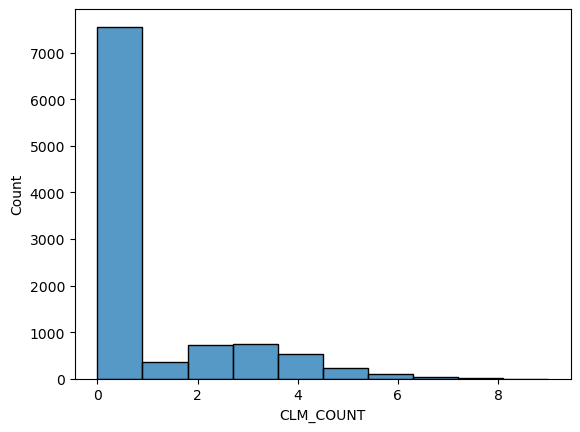

In [10]:
sns.histplot(claim_history['CLM_COUNT'], bins=10)
plt.show()

#### (b) What is the log-likelihood value, the Akaike Information Criterion (AIC) value, and the Bayesian Information Criterion (BIC) value of the Intercept-only model? Here are the formulas for AIC and BIC. Suppose $𝑙$ is the log-likelihood of a model, $𝑝$ is the number of non-aliased parameters in the model, and $𝑛$ is the number of observations used for training the model. Then $𝐴𝐼𝐶=−2𝑙+2𝑝$ and $𝐵𝐼𝐶=−2𝑙+𝑝log𝑒𝑛$.

In [11]:
print("The log-likelihood value = " + str(llk))

p = len(nonAliasParam)
n = n_sample

print("The Akaike Information Criterion (AIC) value = " + str((-2 * llk)+(2*p)))
print("The Bayesian Information Criterion (BIC) value = " + str((-2 * llk)+(p * math.log(n))))

The log-likelihood value = -9202.190712554875
The Akaike Information Criterion (AIC) value = 18406.38142510975
The Bayesian Information Criterion (BIC) value = 18413.03227468598


### QUESTION 2

#### Use the Forward Selection method to build our model. The Entry Threshold is 0.01.

In [12]:
entry_threshold = 0.01
cols = ['index', target, exposure]
smallest_significance = 0.00

for x in range(1, len(train_data.columns)):
    for col in train_data.columns:
        if col not in cols:
            step_detail = []
            i = 0
            for c in train_data.columns:
                if c not in cols:
                    if c in cat_pred:
                        u = train_data[c].astype('category')
                        u_freq = u.value_counts(ascending = True)
                        pm = u.cat.reorder_categories(list(u_freq.index))
                        term_type = pd.get_dummies(pm)
                        X = X_train.join(term_type, rsuffix='_' + c)
                    else:
                        X = X_train.join(train_data[[c]], rsuffix='_' + c)
                    outList = Regression.PoissonRegression(X, y_train, o_train)
                    llk_1 = outList[3]
                    df_1 = len(outList[4])

                    deviance_chisq = 2 * (llk_1 - llk_0)
                    deviance_df = df_1 - df_0
                    deviance_sig = chi2.sf(deviance_chisq, deviance_df)

                    step_detail.append(['+ ' + c, df_1, llk_1, deviance_chisq, deviance_df, deviance_sig])

            step_detail_df = pd.DataFrame(step_detail)
            row = step_detail_df[step_detail_df[5] == step_detail_df[5].min()]
            row = row.values[0]
            cat_name = row[0]
            smallest_significance = row[5]
            if smallest_significance > entry_threshold:
                break
            elif np.isnan(smallest_significance):
                break
            else:
                llk_0 = row[2]
                df_0 = row[1]
                step_summary.append(row)

                cat_name = cat_name.replace('+ ', '')
                if cat_name in cat_pred:
                    u = train_data[cat_name].astype('category')                    
                    u_freq = u.value_counts(ascending = True)
                    pm = u.cat.reorder_categories(list(u_freq.index))
                    term_type = pd.get_dummies(pm)
                    X_train = X_train.join(term_type, rsuffix='_' + cat_name)
                else:
                    X_train = X_train.join(train_data[[cat_name]], rsuffix='_' + cat_name)
                cols.append(cat_name)    

step_summary = pd.DataFrame(step_summary, columns = ['Predictor', '# of Non-Aliased Parameters', 'Log-Likelihood', 'Deviance Chi-Square',
                                                    'Deviance Degree of Freedom', 'Chi-square significance']).reset_index().rename({'index':'Step'}, axis = 1).set_index('Step')

Final_Model = X_train
step_summary

,Predictor,# of Non-Aliased Parameters,Log-Likelihood,Deviance Chi-Square,Deviance Degree of Freedom,Chi-square significance
Step,,,,,,
0,Intercept,1,-9202.190713,NaN,NaN,NaN
1,+ URBANICITY,2,-8796.722613,810.936199,1.0,2.261281e-178
2,+ EDUCATION,6,-8488.805338,615.834550,4.0,5.795205e-132
3,+ MVR_PTS,7,-8349.865822,277.879032,1.0,2.176697e-62
4,+ CAR_TYPE,12,-8234.985620,229.760403,5.0,1.203794e-47
5,+ TRAVTIME,13,-8163.342263,143.286714,1.0,5.087948e-33
6,+ CAR_USE,14,-8097.875925,130.932677,1.0,2.561479e-30
7,+ KIDSDRIV,15,-8049.321029,97.109791,1.0,6.558776e-23
8,+ INCOME,16,-8000.010438,98.621184,1.0,3.057312e-23


#### (b) Our final model is the model when the Forward Selection ends. What are the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) of your final model?

In [13]:
result = Regression.PoissonRegression (X_train, y_train, o_train)

outCoefficient = result[0]
outCovb = result[1]
outCorb = result[2]
llk = result[3]
nonAliasParam = result[4]
outIterationTable = result[5]
y_pred = result[6]

p = len(nonAliasParam)
n = X_train.shape[0]

print("The Akaike Information Criterion (AIC) value = " + str((-2 * llk)+(2*p)))
print("The Bayesian Information Criterion (BIC) value = " + str((-2 * llk)+(p * math.log(n))))

The Akaike Information Criterion (AIC) value = 15752.737727294354
The Bayesian Information Criterion (BIC) value = 15899.05641797139


#### (c) Please show a table of the complete set of parameters of your final model (including the aliased parameters). Besides the parameter estimates, please also include the standard errors, the 95% asymptotic confidence intervals, and the exponentiated parameter estimates. Conventionally, aliased parameters have zero standard errors and confidence intervals.

In [14]:
outCoefficient

,Estimate,Standard Error,Lower 95% CI,Upper 95% CI,Exponentiated
Intercept,-0.401503,0.076407,-0.551257,-0.251749,0.669313
Highly Rural/ Rural,-1.943926,0.081602,-2.103863,-1.783989,0.143141
Highly Urban/ Urban,0.000000,0.000000,0.000000,0.000000,1.000000
PhD,0.139734,0.076870,-0.010929,0.290397,1.149968
Below High Sc,0.477629,0.055029,0.369773,0.585485,1.612247
Masters,-0.068989,0.055441,-0.177651,0.039673,0.933337
High School,0.403391,0.044824,0.315538,0.491244,1.496892
Bachelors,0.000000,0.000000,0.000000,0.000000,1.000000
MVR_PTS,0.080916,0.006532,0.068114,0.093718,1.084280
Panel Truck,-0.038398,0.080251,-0.195687,0.118891,0.962330


### QUESTION 3

#### (a) Calculate the Root Mean Squared Error, the Relative Error, the Pearson correlation, the Distance correlation, and the R-squared metrics for the Intercept-only model.

In [15]:
# Intercept only model
X_train = train_data[[target]]
X_train.insert(0, 'Intercept', 1.0)
X_train = X_train.drop(columns = target)

result = Regression.PoissonRegression (X_train, y_train, o_train)

outCoefficient = result[0]
outCovb = result[1]
outCorb = result[2]
llk = result[3]
nonAliasParam = result[4]
outIterationTable = result[5]
y_pred = result[6]

y_res = y_train - y_pred
y_res_sq = y_res * y_res
rmse = math.sqrt(np.mean(y_res_sq))

print("The Root Mean Squared Error = " + str(rmse))

#Relative error
y_target_mean = np.mean(y_train)
y_re = y_train - y_target_mean
y_re = np.sum(y_re * y_re)
re = np.sum(y_res_sq)/y_re

print("The Relative Error = " + str(re))

#Pearson correlation
pc = np.corrcoef(y_train, y_pred)
print("The Pearson correlation = " + str(pc[0][1]))

def empirical_distance(M):
    m = []
    m_mean = []
    for x in M:
        l = []
        for i in M:
            l.append(abs(x-i))
        m.append(l)
        m_mean.append(sum(l)/len(l))

    m = np.matrix(m)
    m_adjusted = []
    total_mean = sum(m_mean)/len(m_mean)
    c = m.shape[1]
    s = 0
    for i in enumerate(m):
        l = []
        for j in range(c):
            x = m.item(i[0], j) - m_mean[i[0]] - m_mean[j] + total_mean
            s = s + (x*x) 
            l.append(x)
        m_adjusted.append(l)
    vn = s/(c*c)
    return vn, np.matrix(m_adjusted)

def distance_correlation(A, B):
    vn_A, s1 = empirical_distance(A)
    vn_B, s2 = empirical_distance(B)
    s = 0
    for i in enumerate(s1):
        for j in range(s1.shape[1]):
            s = s + (s1.item(i[0], j) * s2.item(i[0], j))

    vn_AB = s/(len(A) * len(B))

    R_squared = vn_AB/(math.sqrt(vn_A * vn_B))
    R = math.sqrt(R_squared)
    
    return R

print(" The Distance Correlation = " + str(distance_correlation(y_train, y_pred)))

#R-squared metric
observed_mean =  np.mean(y_train)
predicted_mean = np.mean(y_pred)
r_sq = np.sum(((y_pred-predicted_mean)*(y_train-observed_mean))**2)/(np.sum((y_pred-predicted_mean)**2)*np.sum((y_train-observed_mean)**2))

print('The R-squared = ' + str(r_sq))

The Root Mean Squared Error = 1.4635157608953973
The Relative Error = 1.0759932377155375
The Pearson correlation = -0.19138309783283639
 The Distance Correlation = 0.2296806817493389
The R-squared = 0.00023764977519819713


#### (b) Calculate the Root Mean Squared Error, the Relative Error, the Pearson correlation, the Distance correlation, and the R-squared metrics for our final model in Question 2.

In [16]:
result = Regression.PoissonRegression (Final_Model, y_train, o_train)

outCoefficient = result[0]
outCovb = result[1]
outCorb = result[2]
llk = result[3]
nonAliasParam = result[4]
outIterationTable = result[5]
y_pred = result[6]

y_res = y_train - y_pred
y_res_sq = y_res * y_res
rmse = math.sqrt(np.mean(y_res_sq))

print("The Root Mean Squared Error = " + str(rmse))

#Relative error
y_target_mean = np.mean(y_train)
y_re = y_train - y_target_mean
y_re = np.sum(y_re * y_re)
re = np.sum(y_res_sq)/y_re

print("The Relative Error = " + str(re))

#Pearson correlation
pc = np.corrcoef(y_train, y_pred)
print("The Pearson correlation = " + str(pc[0][1]))

def empirical_distance(M):
    m = []
    m_mean = []
    for x in M:
        l = []
        for i in M:
            l.append(abs(x-i))
        m.append(l)
        m_mean.append(sum(l)/len(l))

    m = np.matrix(m)
    m_adjusted = []
    total_mean = sum(m_mean)/len(m_mean)
    c = m.shape[1]
    s = 0
    for i in enumerate(m):
        l = []
        for j in range(c):
            x = m.item(i[0], j) - m_mean[i[0]] - m_mean[j] + total_mean
            s = s + (x*x) 
            l.append(x)
        m_adjusted.append(l)
    vn = s/(c*c)
    return vn, np.matrix(m_adjusted)

def distance_correlation(A, B):
    vn_A, s1 = empirical_distance(A)
    vn_B, s2 = empirical_distance(B)
    s = 0
    for i in enumerate(s1):
        for j in range(s1.shape[1]):
            s = s + (s1.item(i[0], j) * s2.item(i[0], j))

    vn_AB = s/(len(A) * len(B))

    R_squared = vn_AB/(math.sqrt(vn_A * vn_B))
    R = math.sqrt(R_squared)
    
    return R

print(" The Distance Correlation = " + str(distance_correlation(y_train, y_pred)))

#R-squared metric
observed_mean =  np.mean(y_train)
predicted_mean = np.mean(y_pred)
r_sq = np.sum(((y_pred-predicted_mean)*(y_train-observed_mean))**2)/(np.sum((y_pred-predicted_mean)**2)*np.sum((y_train-observed_mean)**2))

print('The R-squared = ' + str(r_sq))

The Root Mean Squared Error = 1.3946224733422332
The Relative Error = 0.977075340964604
The Pearson correlation = 0.2614873869285945
 The Distance Correlation = 0.2806093073912489
The R-squared = 0.0002784862880145033


#### (c) We will compare the goodness-of-fit of your model with that of the saturated model. We will calculate the Pearson Chi-Squares and the Deviance Chi-Squares statistics, their degrees of freedom, and their significance values. Based on the results, do you think your model is statistically the same as the saturated Model?

In [17]:
y_train = train_data[target].values
pearson_chi_statistic = np.sum((y_train-y_pred)**2/y_pred)
dof = n_sample-len(nonAliasParam) + 1
di = -((y_train*np.log(y_pred/y_train))+(y_train-y_pred))
dR2 = np.where(y_train > 0.0, di, 0)
devResid = np.where(y_train > y_pred, 1.0, -1.0) * np.where(dR2 > 0.0, np.sqrt(2.0 * dR2), 0.0)
deviance_chisq = np.sum(np.power(devResid, 2.0))
pearson_sig = chi2.sf(pearson_chi_statistic, dof)
deviance_sig = chi2.sf(deviance_chisq, dof)
three_c_output = pd.DataFrame({"Type":["Pearson","Deviance"],"Statistic":[pearson_chi_statistic,deviance_chisq],"Degrees of Freedom":[dof,dof],"Significance":[pearson_sig,deviance_sig]})
three_c_output

,Type,Statistic,Degrees of Freedom,Significance
0,Pearson,54445.804414,5694,0.000000e+00
1,Deviance,7047.060487,5694,1.933853e-32


### QUESTION 4

#### (a) Plot the Pearson residuals versus the observed number of claims.

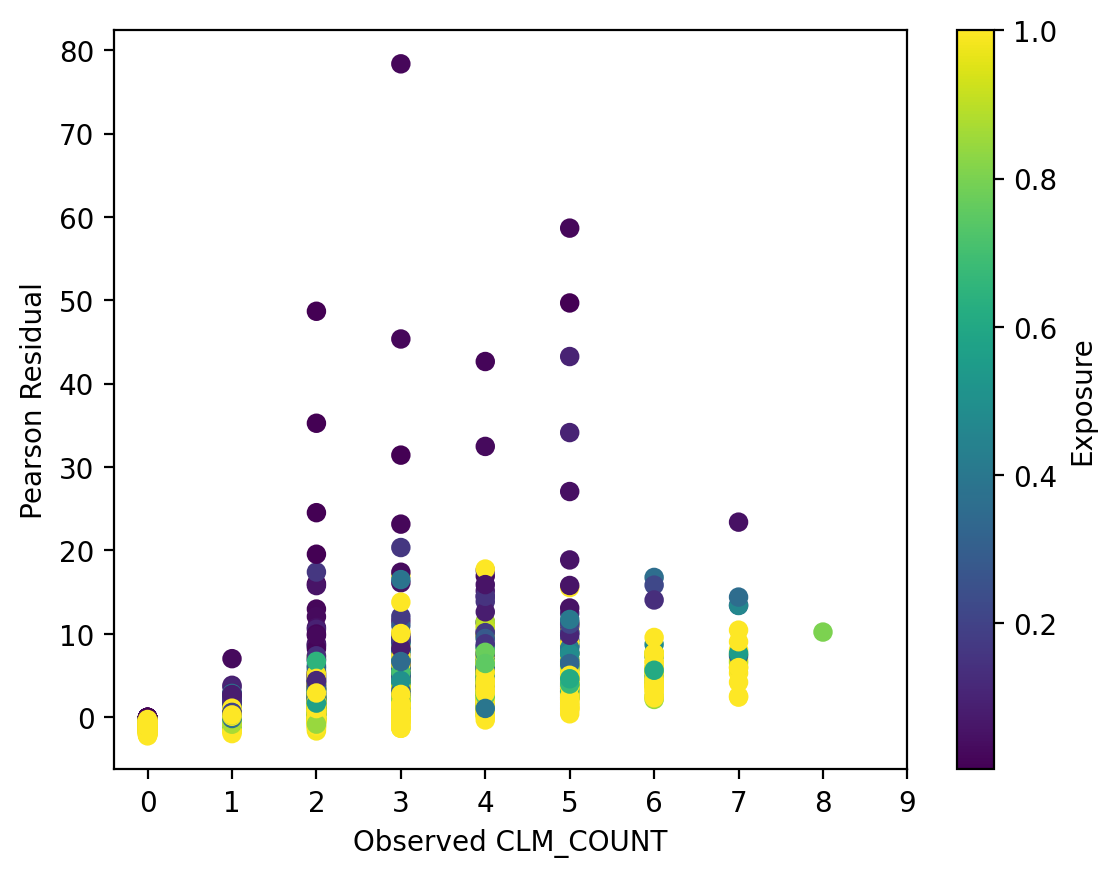

In [18]:
y_resid = y_train - y_pred
pearsonResid = np.where(y_pred > 0.0, y_resid / np.sqrt(y_pred), np.NaN)
plt.figure(dpi = 200)
sg = plt.scatter(y_train, pearsonResid, c = train_data[exposure], marker = 'o',cmap="viridis")
plt.xlabel('Observed CLM_COUNT')
plt.ylabel('Pearson Residual')
plt.xticks(range(10))
plt.grid(axis = 'both')
plt.colorbar(sg, label = 'Exposure')
plt.grid()
plt.show()

#### (b) Plot the Deviance residuals versus the observed number of claims.

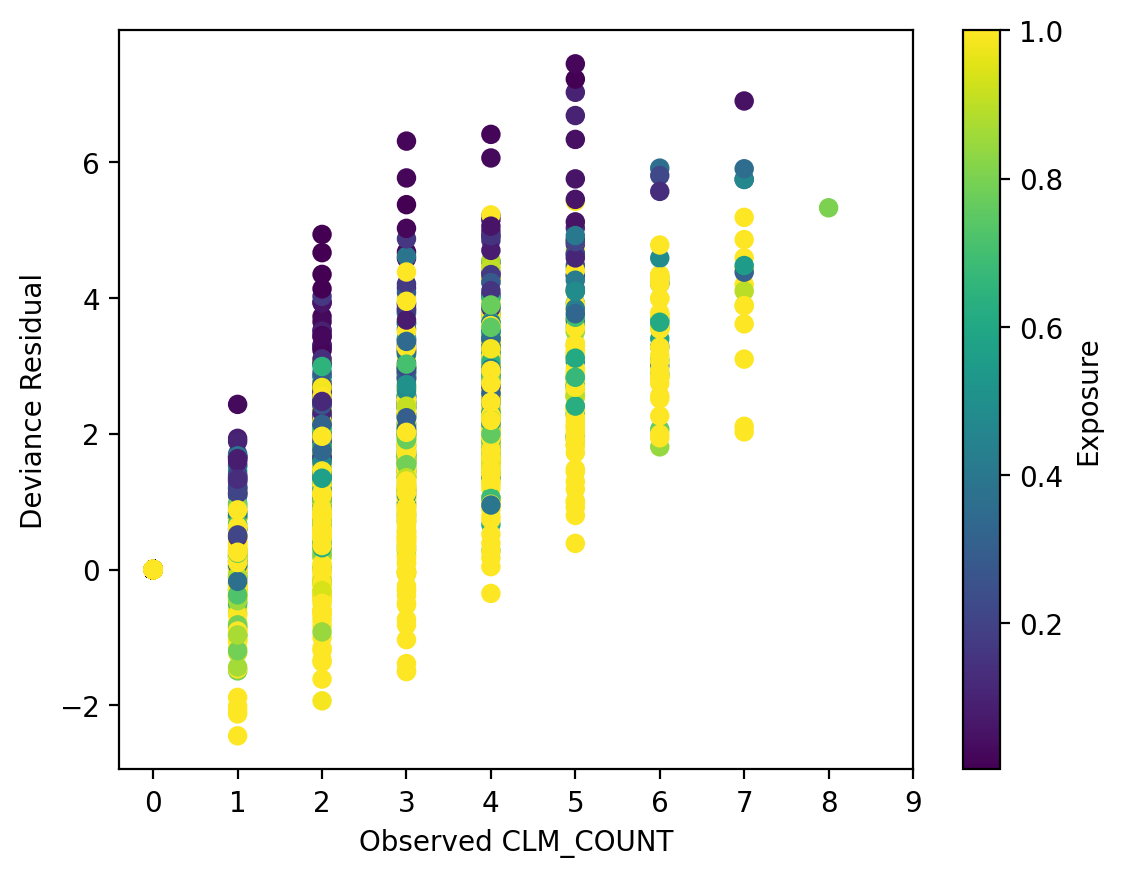

In [19]:
plt.figure(dpi = 200)
sg = plt.scatter(y_train, devResid, c = train_data[exposure], marker = 'o',cmap ="viridis")
plt.xlabel('Observed CLM_COUNT')
plt.ylabel('Deviance Residual')
plt.xticks(range(10))
plt.grid(axis = 'both')
plt.colorbar(sg, label = 'Exposure')
plt.grid()
plt.show()